# IMPORTING LIBS

In [ ]:
%pip install requirements.txt

In [63]:
# 📦 Data Handling
import pandas as pd
import numpy as np

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🧪 Scikit-learn Models & Tools
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# 🚀 XGBoost
from xgboost import XGBRegressor


# IMPORTING DATA

In [24]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sub.csv')

In [25]:
print(df_train.shape)
print(df_test.shape)
print(df_sub.shape)

(934, 63)
(234, 63)
(1459, 62)


In [26]:
numerical_cols = df_train.select_dtypes(include=np.number).columns
categorical_cols = df_train.select_dtypes(include='object').columns

print("Numerical Columns:", numerical_cols)
print("\nCategorical Columns:", categorical_cols)

Numerical Columns: Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces',
       'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold',
       'SalePrice'],
      dtype='object')

Categorical Columns: Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 

In [27]:
df_sub["MasVnrArea"].fillna(0, inplace=True)
df_sub["BsmtFullBath"].fillna(0, inplace=True)

/tmp/ipython-input-27-3785452056.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sub["MasVnrArea"].fillna(0, inplace=True)
/tmp/ipython-input-27-3785452056.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

## Mapping Features for processing

In [28]:
standard_scale = ["MSSubClass", "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "TotalBsmtSF", "2ndFlrSF",
"GrLivArea", "BsmtFullBath", "FullBath", "HalfBath", "Fireplaces", "GarageCars", "WoodDeckSF", "OpenPorchSF"]
leave_num = ["OverallQual", "OverallCond", "KitchenAbvGr", "BedroomAbvGr"]
year_columns = ["YearBuilt", "YearRemodAdd", "MoSold", "YrSold"]


In [29]:
one_encode_cat = ["MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig", "Neighborhood"
, "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
"Foundation", "BsmtFinType1", "BsmtFinType2", "Heating", "Electrical", "Functional", "GarageType", "GarageFinish",
"PavedDrive", "SaleType", "SaleCondition", "LandSlope",
"Functional"]

label_encode = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC", "KitchenQual",
"GarageQual", "GarageCond", ]

binary_encode = ["CentralAir"]

In [30]:
from sklearn.preprocessing import RobustScaler

# Initialize RobustScaler
scaler = RobustScaler()

# Apply to the train, test, and submission datasets
df_train[standard_scale] = scaler.fit_transform(df_train[standard_scale])
df_test[standard_scale] = scaler.transform(df_test[standard_scale])
df_sub[standard_scale] = scaler.transform(df_sub[standard_scale])

In [31]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform on the training data
encoded_train = encoder.fit_transform(df_train[one_encode_cat])
encoded_test = encoder.transform(df_test[one_encode_cat])
encoded_sub = encoder.transform(df_sub[one_encode_cat])

# Create DataFrames from encoded arrays
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(one_encode_cat))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(one_encode_cat))
encoded_sub_df = pd.DataFrame(encoded_sub, columns=encoder.get_feature_names_out(one_encode_cat))

# Drop original categorical columns
df_train = df_train.drop(columns=one_encode_cat)
df_test = df_test.drop(columns=one_encode_cat)
df_sub = df_sub.drop(columns=one_encode_cat)

# Concatenate original dataframes with encoded dataframes
df_train = pd.concat([df_train, encoded_train_df], axis=1)
df_test = pd.concat([df_test, encoded_test_df], axis=1)
df_sub = pd.concat([df_sub, encoded_sub_df], axis=1)

display(df_train.head())

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ
0,252,1.4,-1.445322,-1.184510,8,5,2006,2007,2.829412,Gd,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,862,2.8,0.276901,0.497859,5,4,1965,1965,0.000000,TA,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,852,1.4,0.000000,-1.564786,8,5,2003,2003,0.235294,Gd,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,583,0.8,0.610234,0.550716,6,5,1990,1990,0.611765,TA,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,327,1.4,-2.111988,0.307231,8,5,1993,1993,0.000000,Gd,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [32]:
# Define mapping for ordinal label encoding
ordinal_mapping = {
    "Ex": 5,
    "Gd": 4,
    "TA": 3,
    "Fa": 2,
    "Po": 1,
    "Av": 3,  # Used for BsmtCond
    "Mn": 2,  # Used for BsmtCond
    "No": 1,  # Used for BsmtCond
    "NA": 0,  # Used for features where 'NA' indicates no feature
}


# Function to apply mapping safely
def apply_label_encoding(df, columns, mapping):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(mapping).fillna(0).astype(int)

# Apply to all three DataFrames
apply_label_encoding(df_train, label_encode, ordinal_mapping)
apply_label_encoding(df_test, label_encode, ordinal_mapping)
apply_label_encoding(df_sub, label_encode, ordinal_mapping)


In [33]:
# Define binary mapping for CentralAir
central_air_map = {"N": 0, "Y": 1}

# Apply to all DataFrames
for df in [df_train, df_test, df_sub]:
    if 'CentralAir' in df.columns:
        df['CentralAir'] = df['CentralAir'].map(central_air_map).astype(int)

In [34]:
print(df_train.shape)
print(df_test.shape)
print(df_sub.shape)

(934, 231)
(234, 231)
(1459, 230)


In [35]:
df_sub.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ
0,1461,-0.6,0.554678,0.497125,5,6,1961,1961,0.000000,3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1462,-0.6,0.610234,1.144378,6,6,1958,1958,0.635294,3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1463,0.2,0.221345,1.037440,5,5,1997,1998,0.000000,3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1464,0.2,0.443567,0.094824,6,6,1998,1998,0.117647,3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1465,1.4,-1.500877,-1.122109,8,5,1992,1992,0.000000,4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
object_cols = df_train.select_dtypes(include='object').columns
print("Object type columns in df_train:", object_cols)

Object type columns in df_train: Index([], dtype='object')


In [37]:
df_sub.fillna(0, inplace=True)

# ================================
# Base Model Class Template
# ================================

In [53]:
class BaseModelRunner:
    def __init__(self, model, param_grid, model_name):
        self.model = model
        self.param_grid = param_grid
        self.model_name = model_name
        self.best_model = None

    def train(self, X, y):
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        grid = GridSearchCV(self.model, self.param_grid, cv=cv,
                            scoring='neg_root_mean_squared_error', n_jobs=-1)
        grid.fit(X, y)
        self.best_model = grid.best_estimator_
        print(f"✅ {self.model_name} Best Parameters:", grid.best_params_)

    def evaluate(self, X_test, y_test):
        y_pred = self.best_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print(f"\n📌 {self.model_name} Evaluation:")
        print(f"RMSE: {rmse:.2f} | R²: {r2:.4f} | MAE: {mae:.2f}")
        return y_pred, rmse, r2, mae

    def predict_submission(self, X_sub, df_sub, filename):
        preds = self.best_model.predict(X_sub)
        submission = df_sub[['Id']].copy()
        submission['SalePrice'] = preds
        submission.to_csv(filename, index=False)
        print(f"📁 Submission saved: {filename}")

# ================================
# Model Configurations
# ================================

## Data Prep

In [51]:
# Prepare data
X_train = df_train.drop(columns=['Id', 'SalePrice']).values
y_train = df_train['SalePrice'].values
X_test = df_test.drop(columns=['Id', 'SalePrice']).values
y_test = df_test['SalePrice'].values
X_sub = df_sub.drop(columns=['Id']).values

# Decision Tree

In [54]:
# Decision Tree
tree_params = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
tree_model = BaseModelRunner(DecisionTreeRegressor(random_state=42), tree_params, "Decision Tree")
tree_model.train(X_train, y_train)
y_pred_tree, rmse_tree, r2_tree, mae_tree = tree_model.evaluate(X_test, y_test)
tree_model.predict_submission(X_sub, df_sub, "decision_tree_submission.csv")

✅ Decision Tree Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

📌 Decision Tree Evaluation:
RMSE: 40780.62 | R²: 0.7427 | MAE: 26939.73
📁 Submission saved: decision_tree_submission.csv


# XGBoost Base

In [55]:
# XGBoost Base
xgb_base_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
xgb_base_model = BaseModelRunner(XGBRegressor(objective='reg:squarederror', random_state=42),
                                 xgb_base_params, "XGBoost Base")
xgb_base_model.train(X_train, y_train)
y_pred_xgb, rmse_xgb, r2_xgb, mae_xgb = xgb_base_model.evaluate(X_test, y_test)
xgb_base_model.predict_submission(X_sub, df_sub, "xgboost_submission.csv")

✅ XGBoost Base Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

📌 XGBoost Base Evaluation:
RMSE: 25422.12 | R²: 0.9000 | MAE: 16081.61
📁 Submission saved: xgboost_submission.csv


# XGBoost with Regularization

In [57]:
# XGBoost with Regularization
xgb_reg_params = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.1],
    'subsample': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1.0, 5.0]
}
xgb_reg_model = BaseModelRunner(XGBRegressor(objective='reg:squarederror', random_state=42),
                                xgb_reg_params, "XGBoost + Regularization")
xgb_reg_model.train(X_train, y_train)
y_pred_xgb_reg, rmse_xgb_reg, r2_xgb_reg, mae_xgb_reg = xgb_reg_model.evaluate(X_test, y_test)
xgb_reg_model.predict_submission(X_sub, df_sub, "xgboost_regularized_submission.csv")


✅ XGBoost + Regularization Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 5.0, 'subsample': 0.8}

📌 XGBoost + Regularization Evaluation:
RMSE: 29966.73 | R²: 0.8611 | MAE: 17574.41
📁 Submission saved: xgboost_regularized_submission.csv


# XGBoost Full Data (Train + Test Combined)

In [58]:
# XGBoost Full Data (Train + Test Combined)
df_full = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
X_full = df_full.drop(columns=['Id', 'SalePrice']).values
y_full = df_full['SalePrice'].values

xgb_full_model = BaseModelRunner(XGBRegressor(objective='reg:squarederror', random_state=42),
                                 xgb_base_params, "XGBoost (Full Data)")
xgb_full_model.train(X_full, y_full)
# No evaluation on test set — full data used
xgb_full_model.predict_submission(X_sub, df_sub, "xgboost_full_training_submission.csv")


✅ XGBoost (Full Data) Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
📁 Submission saved: xgboost_full_training_submission.csv


# ================================
# 🔍 Plotting Accuracy Comparison
# ================================

# Metrics Summary

In [59]:
# Metrics Summary
models = ["Decision Tree", "XGBoost", "XGBoost + Reg", "XGBoost (Full)"]
rmses = [rmse_tree, rmse_xgb, rmse_xgb_reg, np.nan]  # No test eval for full model
r2s = [r2_tree, r2_xgb, r2_xgb_reg, np.nan]
maes = [mae_tree, mae_xgb, mae_xgb_reg, np.nan]

In [60]:
# Create bar plots
x = np.arange(len(models))
width = 0.25

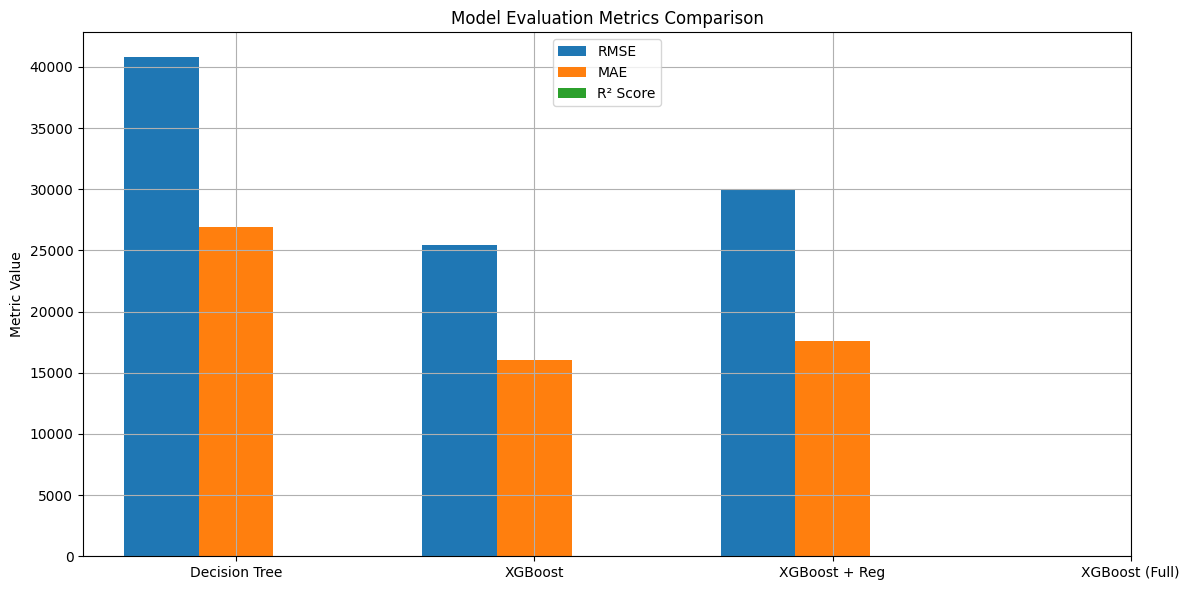

In [61]:
plt.figure(figsize=(12, 6))
plt.bar(x - width, rmses, width, label='RMSE')
plt.bar(x, maes, width, label='MAE')
plt.bar(x + width, r2s, width, label='R² Score')
plt.xticks(x, models)
plt.ylabel("Metric Value")
plt.title("Model Evaluation Metrics Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save Model

In [62]:
import pickle

# Save Decision Tree model
with open('decision_tree_model.pkl', 'wb') as f:
    pickle.dump(tree_model.best_model, f)

# Save XGBoost Base model
with open('xgboost_base_model.pkl', 'wb') as f:
    pickle.dump(xgb_base_model.best_model, f)

# Save XGBoost with Regularization model
with open('xgboost_regularized_model.pkl', 'wb') as f:
    pickle.dump(xgb_reg_model.best_model, f)

# Save XGBoost Full Data model
with open('xgboost_full_data_model.pkl', 'wb') as f:
    pickle.dump(xgb_full_model.best_model, f)

print("✅ All models saved as .pkl files.")


✅ All models saved as .pkl files.
